In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd

from keras_transfer_learning.utils import visualize, utils
visualize.set_default_plotting_tex()

Using TensorFlow backend.
/home/benjamin/miniconda3/envs/bachelorthesis/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

## Utils

In [3]:
facetgrid_kwargs = dict(height=1.92, aspect=1, # 1.92 inches wide and high
                        palette=sns.color_palette(),
                        )
catplot_kwargs = dict(size=2,                # Size of the dots
                      dodge=True,            # Seperate hues
                      **facetgrid_kwargs
                      )

def exp_regex(exps):
    return '|'.join([f'((R/none|P/{p})/{d}/{h}/{b}/.*)' for p, d, h, b in exps])

def convert_to_categorical(df):
    df['Data'] = df['Data'].astype('category')
    df['Pretraining Data'] = df['Pretraining Data'].astype('category')
    return df

def rename_datasets(df):
    data_name_map = {
        'hl60low': 'HL60_LOW_NOISE',
        'hl60high': 'HL60_HIGH_NOISE',
        'granulocyte': 'GRANULOCYTE',
        'dsb2018': 'DSB2018',
        'imagenet': 'IMAGENET',
        'cityscapes': 'CITYSCAPES',
        'hl60low-hl60high-granulocyte': 'SIMULATED',
        'hl60low-granulocyte-aug': 'SIMULATED_AUG',
    }
    df['Data'] = df['Data'].cat.rename_categories(data_name_map)
    df['Pretraining Data'] = df['Pretraining Data'].cat.rename_categories(data_name_map)
    return df

def fill_pretrain_data(df):
    results_random = df[df['Pretraining Data'].isnull()]
    pretrain_datas = [c for c in df['Pretraining Data'].unique() if c is not None]
    results_random_filled = [results_random[results_random['Data'] != d].fillna(d) for d in pretrain_datas]

    df = df[df['Pretraining Data'].notnull()]
    for d in results_random_filled:
        df = df.append(d)
    return df

def add_joined_data_col(df):
    df['Joined Data'] = df[['Data', 'Pretraining Data']].apply(
        lambda x: f'Pretraining: {x[1]}\nData: {x[0]}', axis=1)
    return df

# Swarmplots for the scores

## Pretrain on simulated datasets

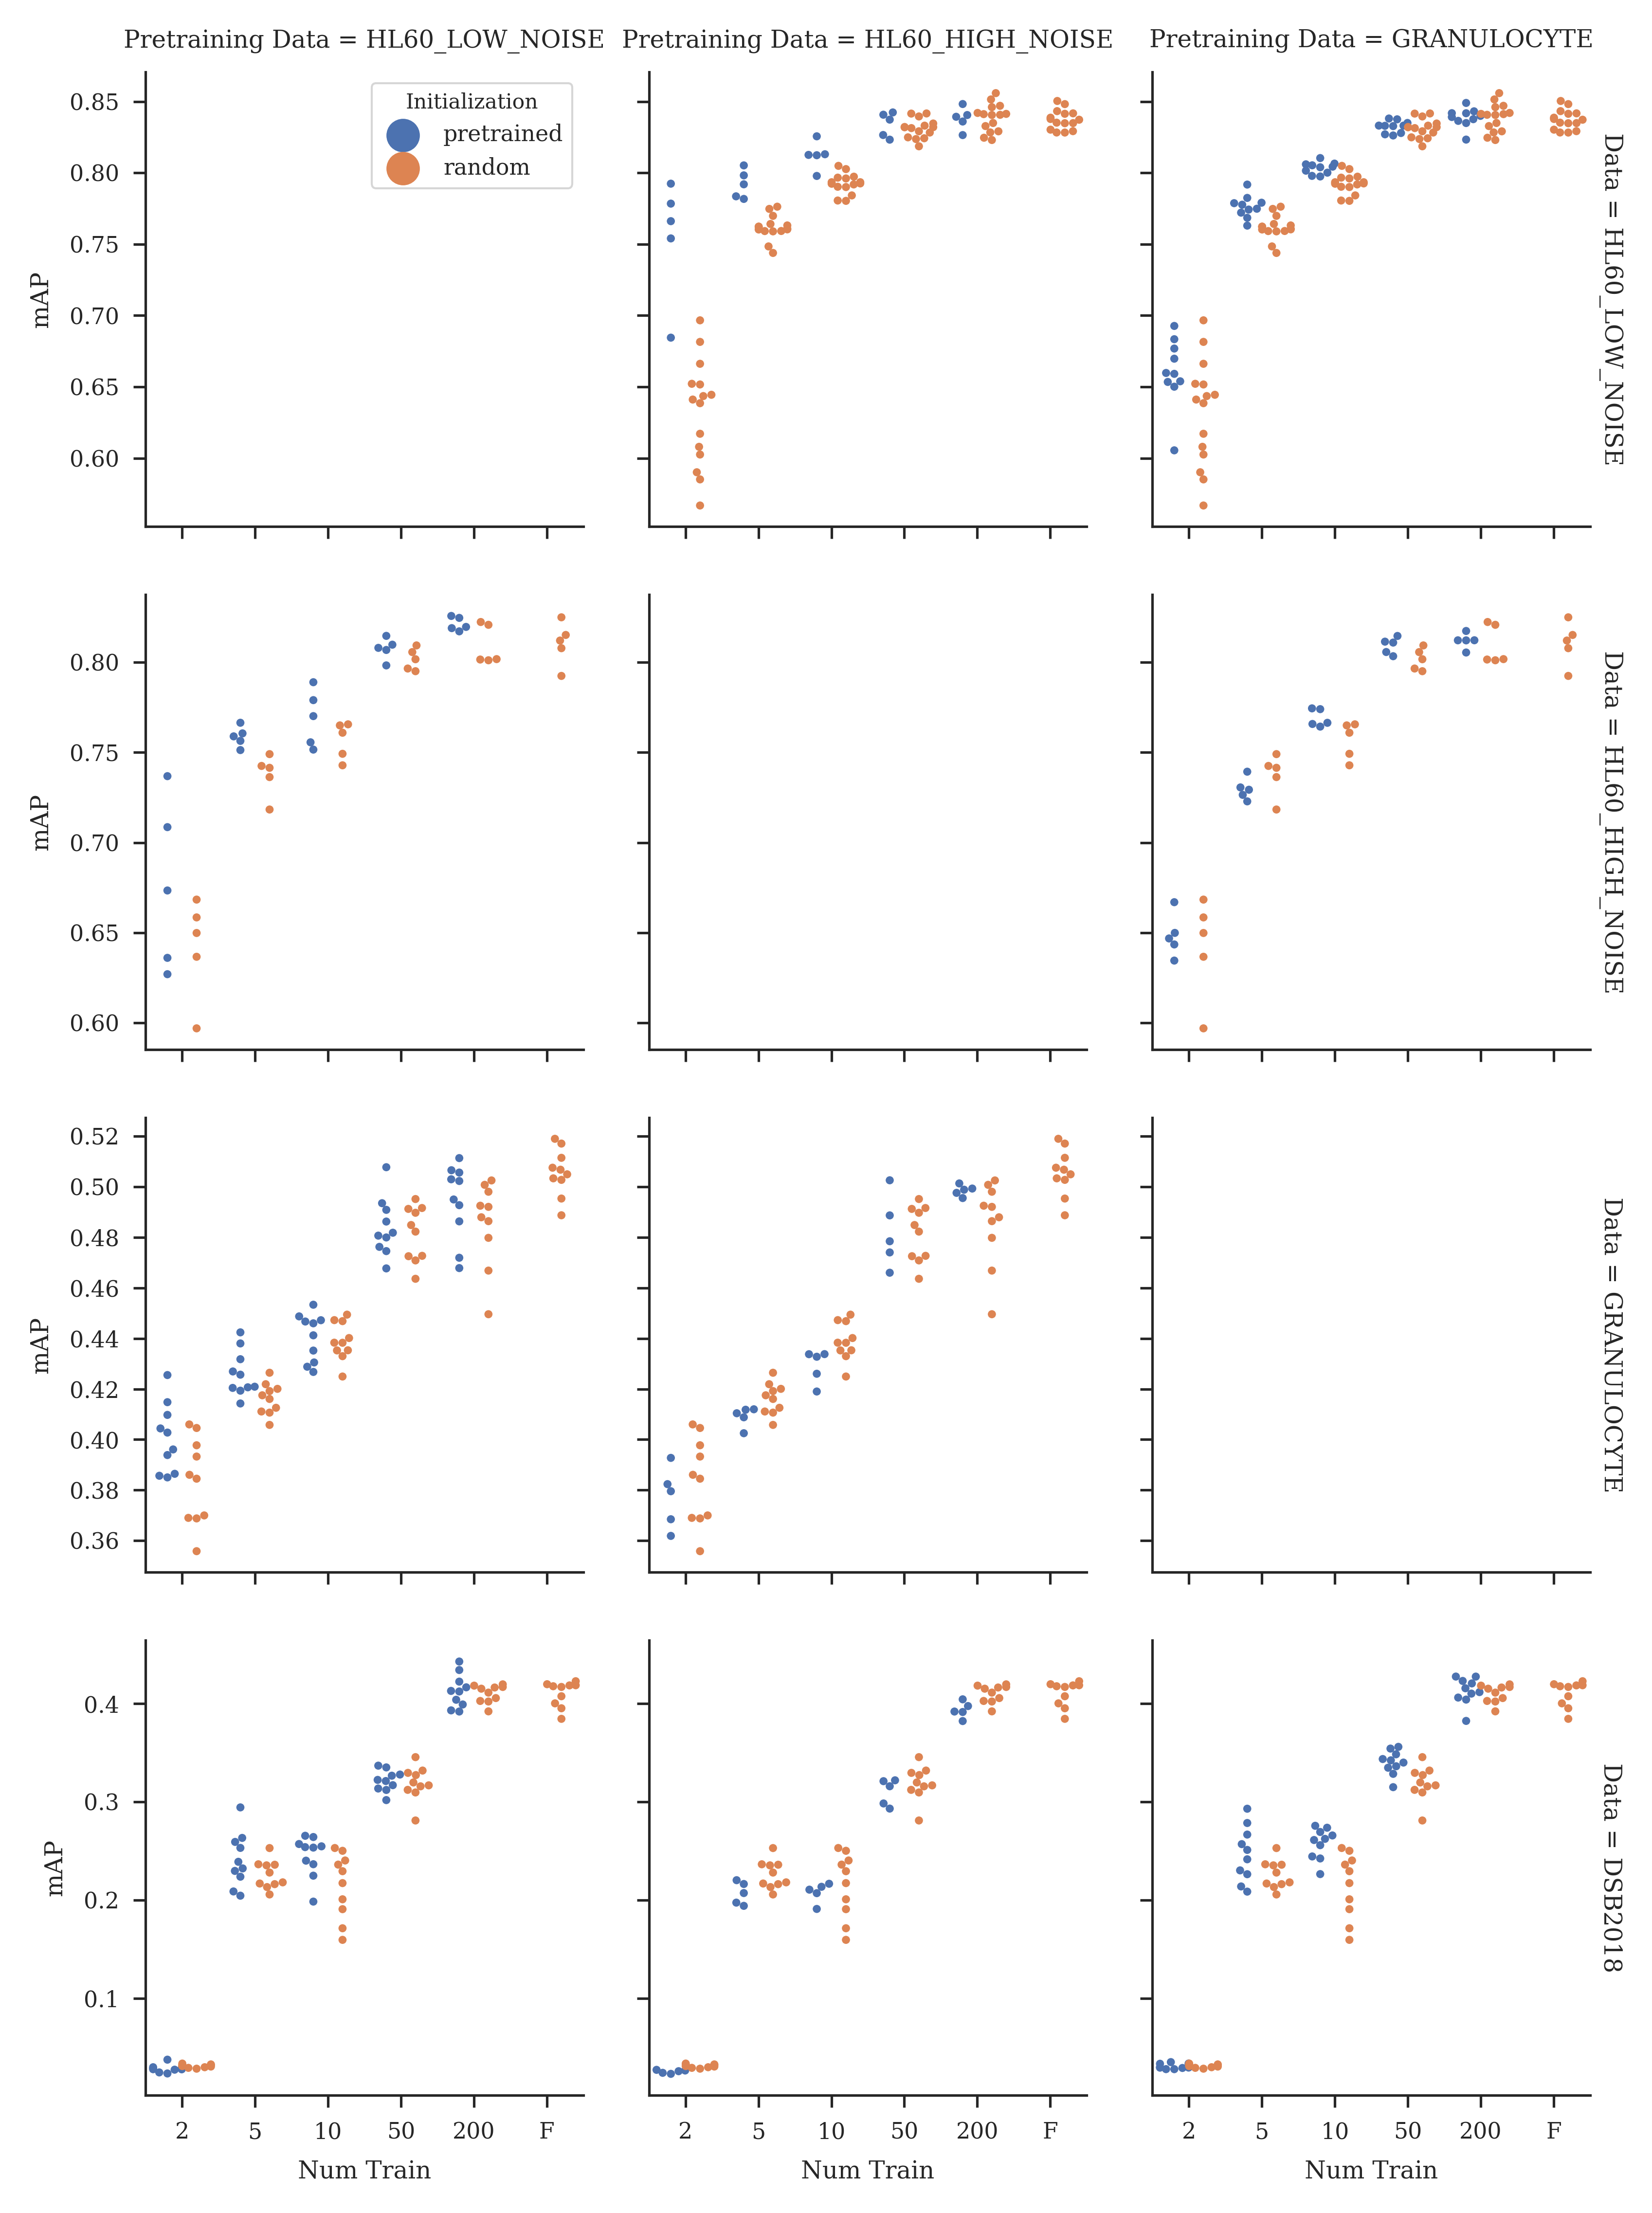

In [4]:
exps = [
    # HL60 Low Noise
    ('hl60low', 'hl60high', 'stardist', 'unet'),
    ('hl60low', 'granulocyte', 'stardist', 'unet'),
    ('hl60low', 'dsb2018', 'stardist', 'unet'),
    
    # HL60 High Noise
    ('hl60high', 'hl60low', 'stardist', 'unet'),
    ('hl60high', 'granulocyte', 'stardist', 'unet'),
    ('hl60high', 'dsb2018', 'stardist', 'unet'),
    
    # Granulocyte
    ('granulocyte', 'hl60low', 'stardist', 'unet'),
    ('granulocyte', 'hl60high', 'stardist', 'unet'),
    ('granulocyte', 'dsb2018', 'stardist', 'unet'),
]

selected_models = visualize.get_models(exp_regex(exps))
results_last_df = visualize._get_results_last_df(selected_models, 'ap_dsb2018#mean')

results_last_df = fill_pretrain_data(results_last_df)
results_last_df = convert_to_categorical(results_last_df)
results_last_df = rename_datasets(results_last_df)

# Plot
g = visualize.catplot(
    data=results_last_df,
    col='Pretraining Data', row='Data',
    x='Num Train', y='mAP', hue='Initialization',
    row_order=['HL60_LOW_NOISE', 'HL60_HIGH_NOISE', 'GRANULOCYTE', 'DSB2018'],
    col_order=['HL60_LOW_NOISE', 'HL60_HIGH_NOISE', 'GRANULOCYTE'],
    sharey='row', margin_titles=True, legend_out=False,
    **catplot_kwargs
)
plt.subplots_adjust(hspace=0.15, wspace=0.15)

visualize.save(g, '/tmp/bachelorthesis-plots-tex/pretrain_sim_map.pdf')

## Pretrain on DSB2018

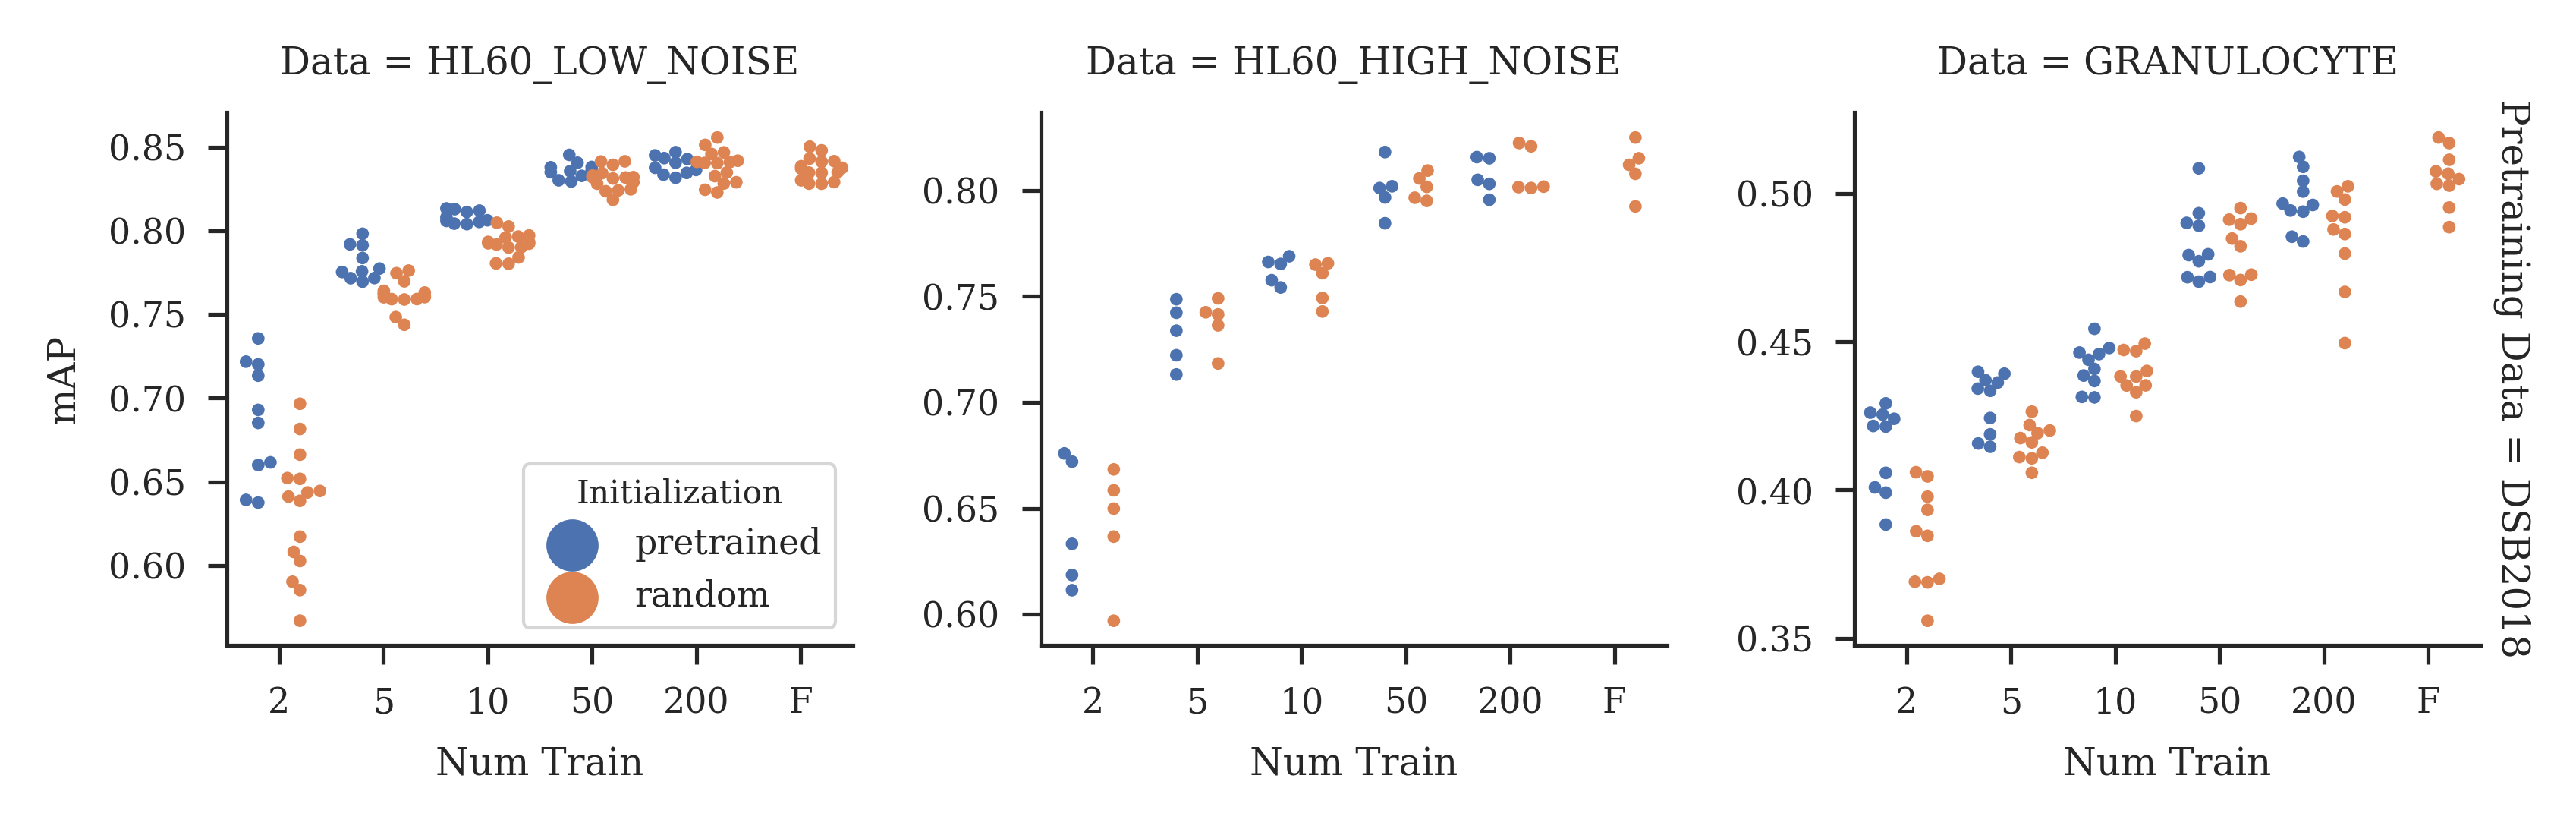

In [5]:
exps = [
    ('dsb2018', 'hl60low', 'stardist', 'unet'),
    ('dsb2018', 'hl60high', 'stardist', 'unet'),
    ('dsb2018', 'granulocyte', 'stardist', 'unet'),
]
selected_models = visualize.get_models(exp_regex(exps))
results_last_df = visualize._get_results_last_df(selected_models, 'ap_dsb2018#mean')

results_last_df = fill_pretrain_data(results_last_df)
results_last_df = convert_to_categorical(results_last_df)
results_last_df = rename_datasets(results_last_df)

g = visualize.catplot(
    data=results_last_df,
    col='Data', row='Pretraining Data',
    x='Num Train', y='mAP', hue='Initialization',
    row_order=['DSB2018'],
    col_order=['HL60_LOW_NOISE', 'HL60_HIGH_NOISE', 'GRANULOCYTE'],
    sharey=False, margin_titles=True, legend_out=False,
    **catplot_kwargs
)
plt.subplots_adjust(wspace=0.3)

g.savefig('/tmp/bachelorthesis-plots-tex/pretrain_dsb2018_map.pdf', bbox_inches='tight')

## Pretrain on real-world images

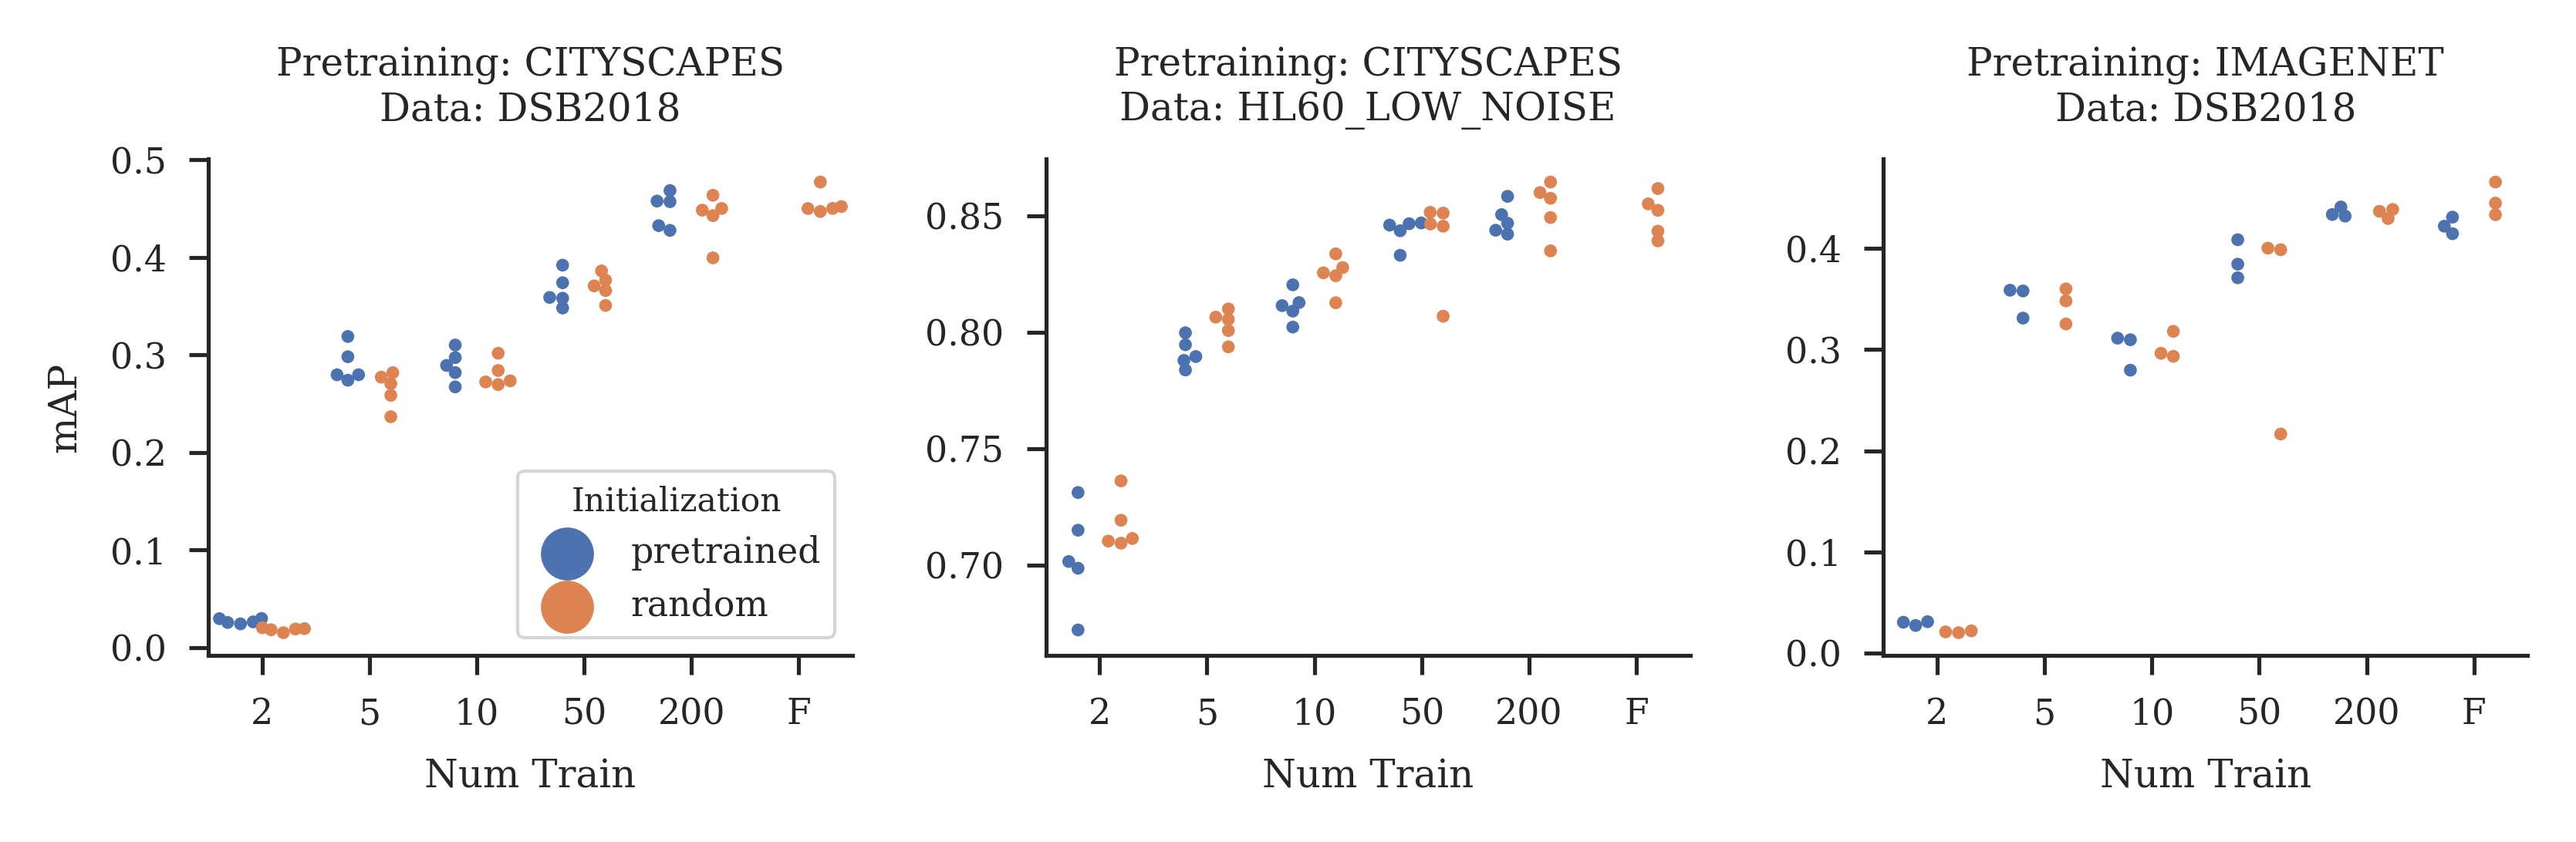

In [6]:
exps = [
    ('cityscapes', 'hl60low', 'stardist', 'resnet-unet'),
    ('cityscapes', 'dsb2018', 'stardist', 'resnet-unet'),
    ('imagenet', 'dsb2018', 'stardist', 'imagenet-resnet-unet'),
]
selected_models = visualize.get_models(exp_regex(exps))
results_last_df = visualize._get_results_last_df(selected_models, 'ap_dsb2018#mean')

df_1 = results_last_df[results_last_df['Backbone'] == 'resnet-unet'].fillna('cityscapes')
df_2 = results_last_df[results_last_df['Backbone'] == 'imagenet-resnet-unet'].fillna('imagenet')
results_last_df = df_1.append(df_2)

results_last_df = convert_to_categorical(results_last_df)
results_last_df = rename_datasets(results_last_df)
results_last_df = add_joined_data_col(results_last_df)

g = visualize.catplot(
    data=results_last_df,
    col='Joined Data',
    x='Num Train', y='mAP', hue='Initialization',
    col_order=['Pretraining: CITYSCAPES\nData: DSB2018',
               'Pretraining: CITYSCAPES\nData: HL60_LOW_NOISE',
               'Pretraining: IMAGENET\nData: DSB2018'],
    sharey=False, margin_titles=False, legend_out=False,
    **catplot_kwargs
)
g.set_titles(col_template = '{col_name}')
plt.subplots_adjust(wspace=0.3)

g.savefig('/tmp/bachelorthesis-plots-tex/pretrain_real_map.pdf', bbox_inches='tight')

## Pretrain on multiple datasets

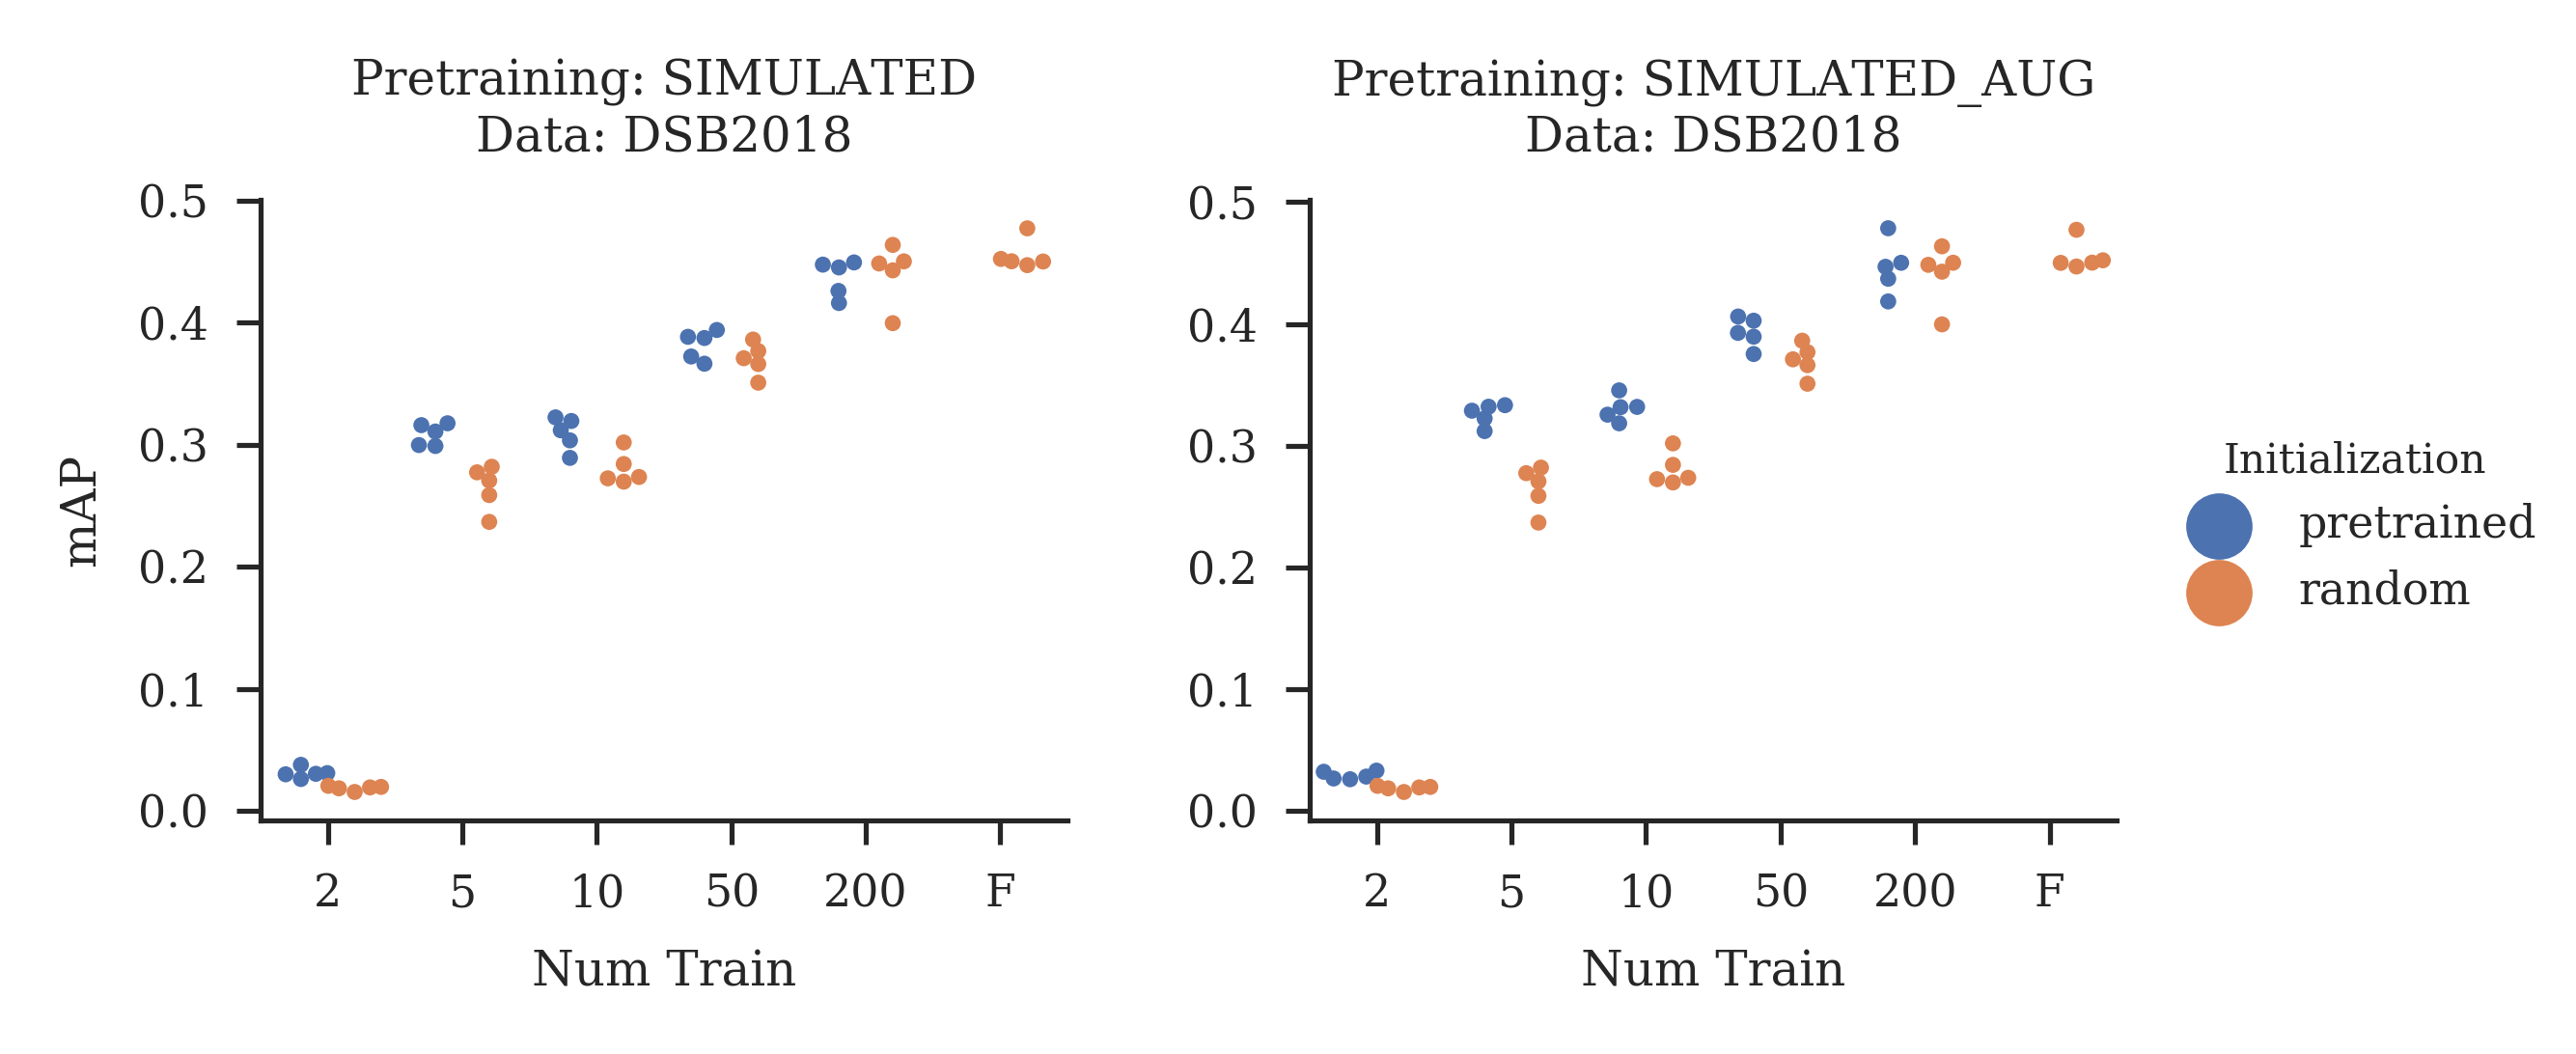

In [7]:
exps = [
    ('hl60low-granulocyte-aug', 'dsb2018', 'stardist', 'resnet-unet'),
    ('hl60low-hl60high-granulocyte', 'dsb2018', 'stardist', 'resnet-unet')
]
selected_models = visualize.get_models(exp_regex(exps))
results_last_df = visualize._get_results_last_df(selected_models, 'ap_dsb2018#mean')



results_last_df = fill_pretrain_data(results_last_df)
results_last_df = convert_to_categorical(results_last_df)
results_last_df = rename_datasets(results_last_df)
results_last_df = add_joined_data_col(results_last_df)

g = visualize.catplot(
    data=results_last_df,
    col='Joined Data',
    x='Num Train', y='mAP', hue='Initialization',
    col_order=['Pretraining: SIMULATED\nData: DSB2018',
               'Pretraining: SIMULATED_AUG\nData: DSB2018'],
    sharey=False, margin_titles=False, legend_out=True,
    **catplot_kwargs
)
plt.subplots_adjust(wspace=0.3)
g.set_titles(col_template = '{col_name}')

g.savefig('/tmp/bachelorthesis-plots-tex/pretrain_mult_map.pdf', bbox_inches='tight')

# Line plots

## Pretrain on simulated datasets

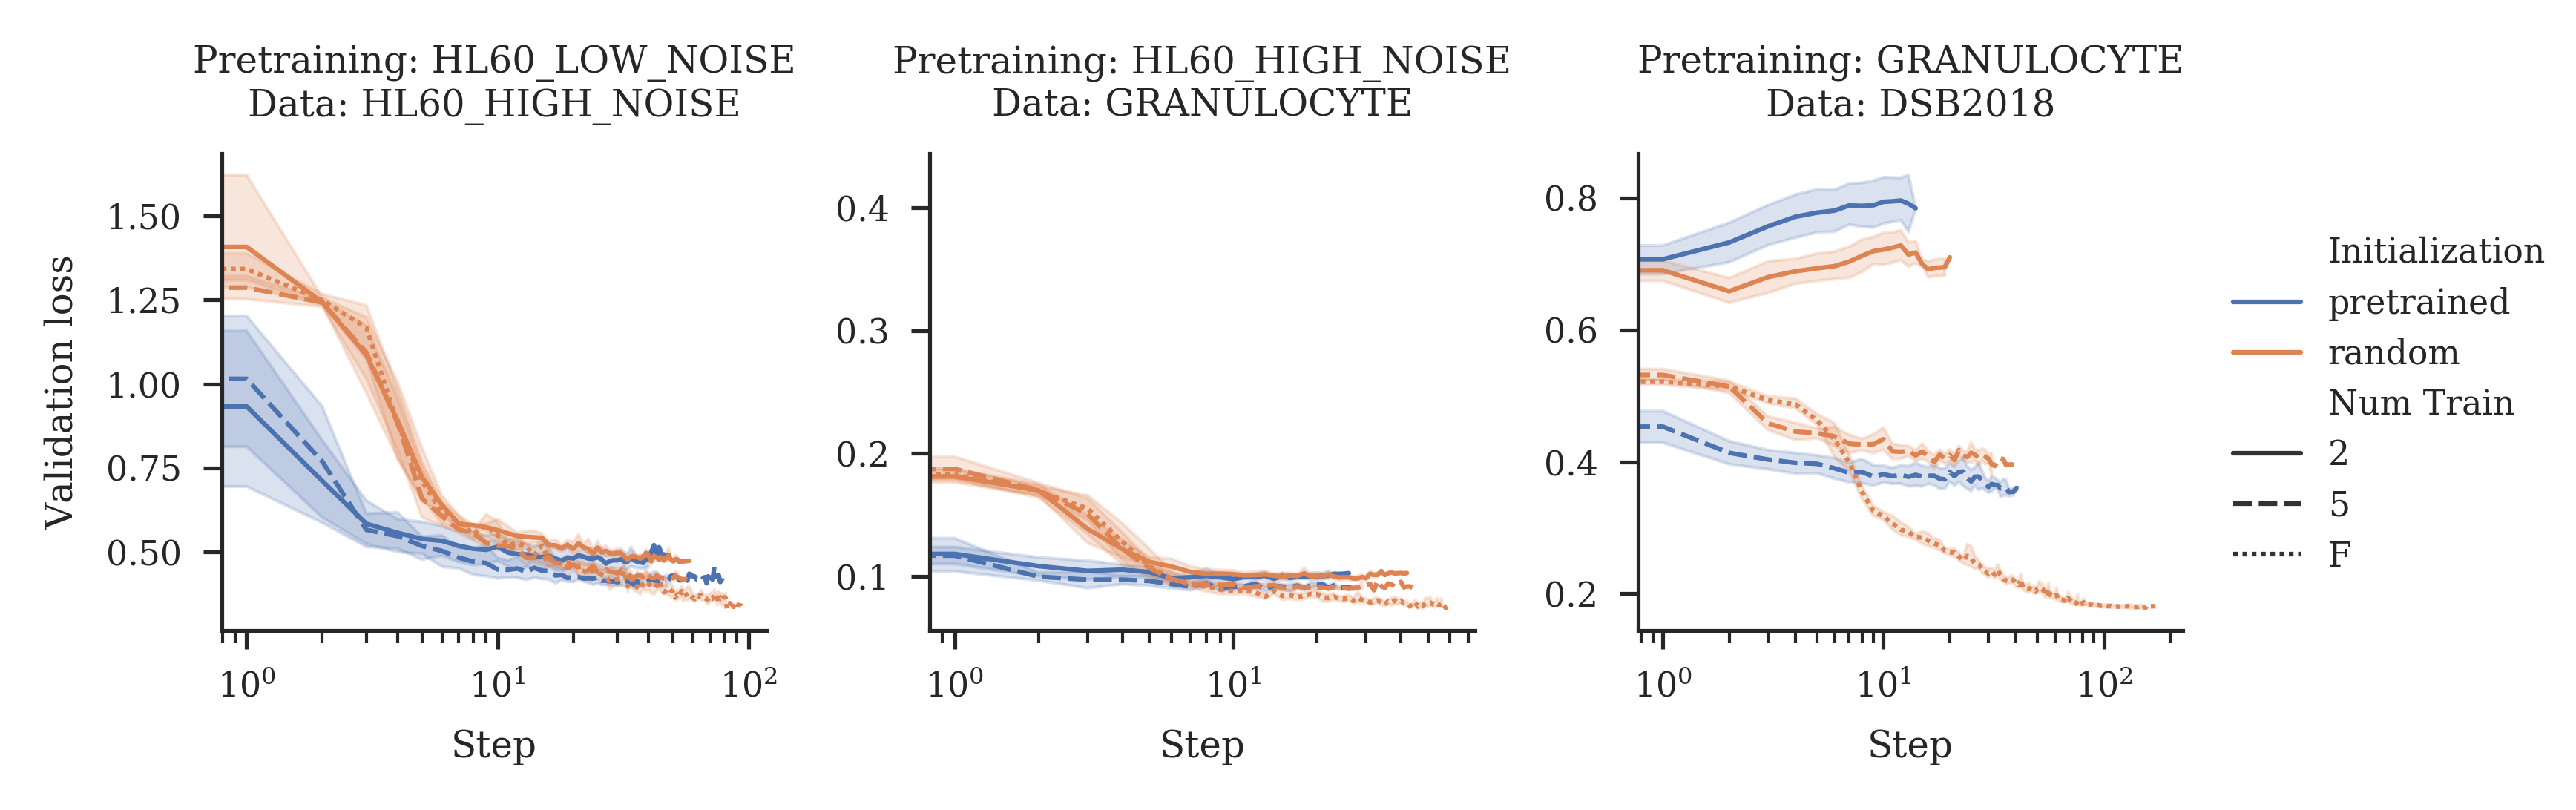

In [8]:
exps = [
    ('hl60low', 'hl60high', 'stardist', 'unet'),
    ('hl60high', 'granulocyte', 'stardist', 'unet'),
    ('granulocyte', 'dsb2018', 'stardist', 'unet'),
]
selected_models = visualize.get_models(exp_regex(exps))
history_df = visualize._get_model_histories_df(selected_models)

# TODO other num train for the dsb dataset?
history_df = history_df[history_df['Num Train'].isin([2, 5, 'F'])]

history_df = fill_pretrain_data(history_df)
history_df = convert_to_categorical(history_df)
history_df = rename_datasets(history_df)
history_df = add_joined_data_col(history_df)
history_df['Validation loss'] = history_df['val_loss']


current_facetgrid_kwargs = dict(**facetgrid_kwargs)
current_facetgrid_kwargs['aspect'] = 0.88
g = sns.FacetGrid(
    data=history_df,
    col='Joined Data',
    col_order=['Pretraining: HL60_LOW_NOISE\nData: HL60_HIGH_NOISE',
               'Pretraining: HL60_HIGH_NOISE\nData: GRANULOCYTE',
               'Pretraining: GRANULOCYTE\nData: DSB2018',],
    sharey=False, sharex=False, legend_out=True,
    **current_facetgrid_kwargs
)
g.map_dataframe(sns.lineplot, 'Step', 'Validation loss', style='Num Train', hue='Initialization')
plt.subplots_adjust(wspace=0.3)

g.set_titles(col_template = '{col_name}')
# g.axes[0,0].set(ylim=(0.3, 0.6), yscale='log', xscale='log')
# g.axes[0,2].set(ylim=(0.06, 0.13), yscale='log', xscale='log')
# g.axes[0,0].set(yscale='log', xscale='log')
# g.axes[0,1].set(yscale='log', xscale='log')
# g.axes[0,2].set(yscale='log', xscale='log')
g.set(xscale='log')

g.add_legend()

visualize.save(g, '/tmp/bachelorthesis-plots-tex/history_sim.pdf')

# Pretrain on DSB2018

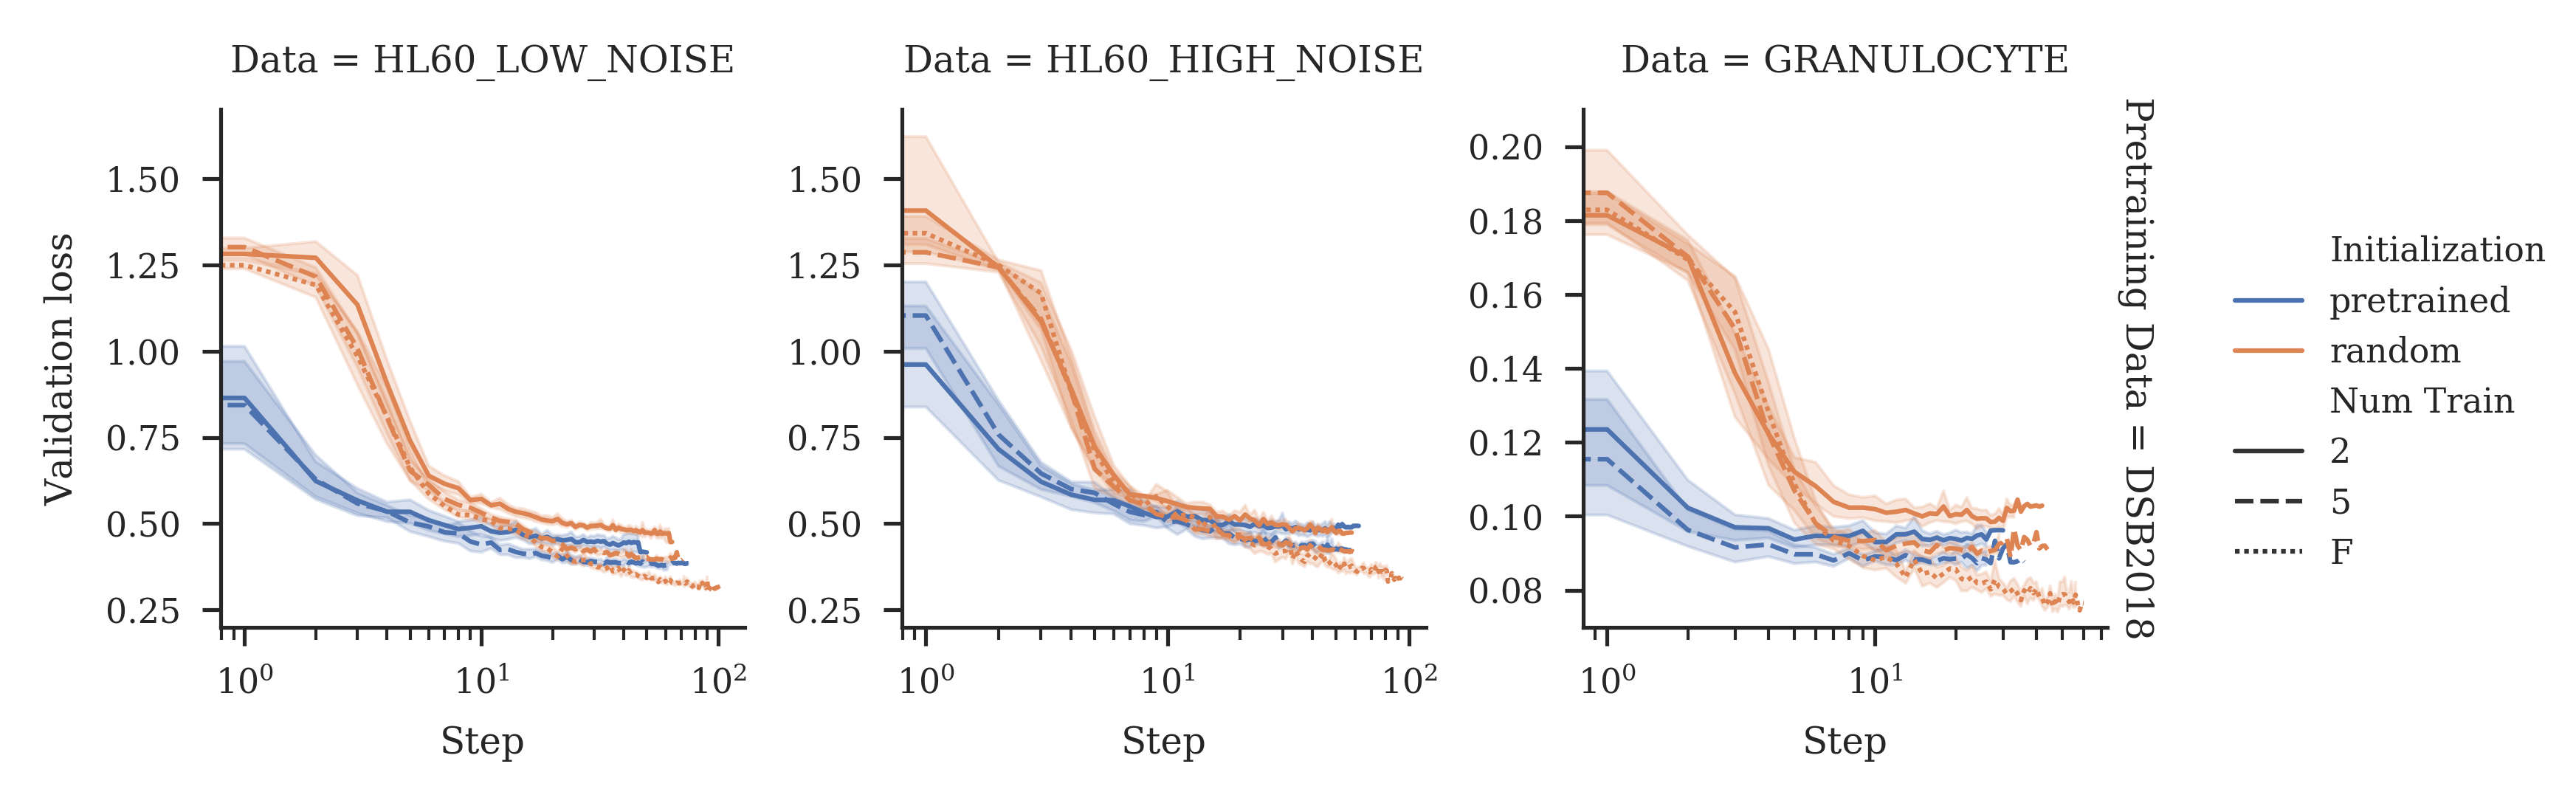

In [9]:
exps = [
    ('dsb2018', 'hl60low', 'stardist', 'unet'),
    ('dsb2018', 'hl60high', 'stardist', 'unet'),
    ('dsb2018', 'granulocyte', 'stardist', 'unet'),
]
selected_models = visualize.get_models(exp_regex(exps))
history_df = visualize._get_model_histories_df(selected_models)

history_df = history_df[history_df['Num Train'].isin([2, 5, 'F'])]
history_df = fill_pretrain_data(history_df)
history_df = convert_to_categorical(history_df)
history_df = rename_datasets(history_df)
history_df = add_joined_data_col(history_df)
history_df['Validation loss'] = history_df['val_loss']

current_facetgrid_kwargs = dict(**facetgrid_kwargs)
current_facetgrid_kwargs['aspect'] = 0.88
g = sns.FacetGrid(
    data=history_df,
    col='Data', row='Pretraining Data',
    col_order=['HL60_LOW_NOISE', 'HL60_HIGH_NOISE', 'GRANULOCYTE'],
    sharey=False, sharex=False, legend_out=True,
    margin_titles=True,
    **current_facetgrid_kwargs
)
g.map_dataframe(sns.lineplot, 'Step', 'Validation loss', style='Num Train', hue='Initialization')
plt.subplots_adjust(wspace=0.3)

# Set the axis scales and lim
g.set(xscale='log')
g.axes[0,0].set(ylim=(0.2, 1.7))
g.axes[0,1].set(ylim=(0.2, 1.7))
g.axes[0,2].set(ylim=(0.07, 0.21))

g.add_legend()

visualize.save(g, '/tmp/bachelorthesis-plots-tex/history_dsb2018.pdf')

## Pretrain on real world

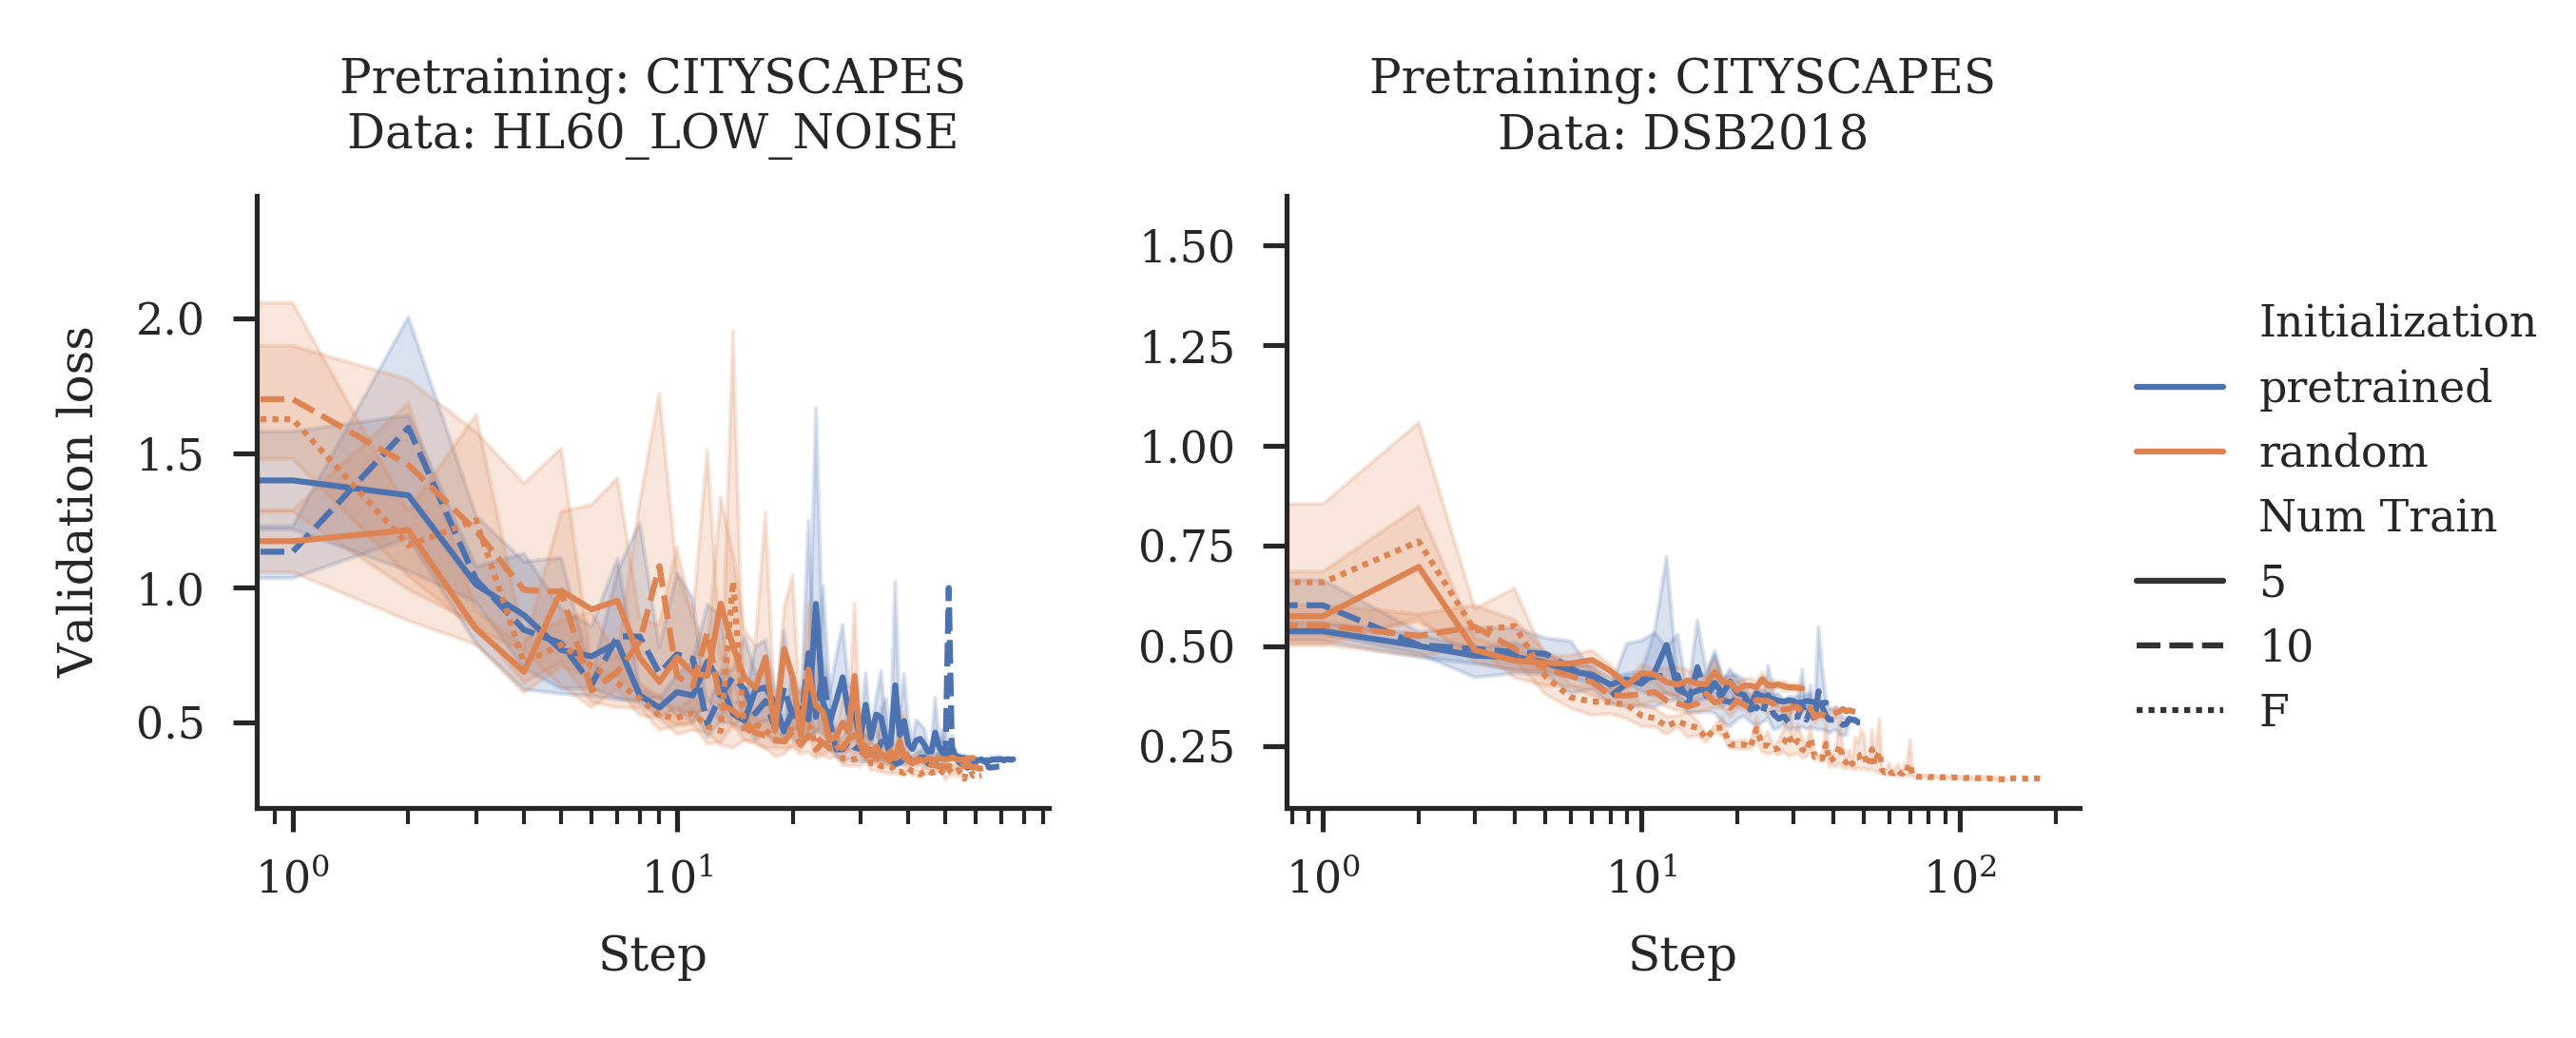

In [10]:
exps = [
    ('cityscapes', 'hl60low', 'stardist', 'resnet-unet'),
    ('cityscapes', 'dsb2018', 'stardist', 'resnet-unet'),
    # TODO include this experiment?
    #('imagenet', 'dsb2018', 'stardist', 'imagenet-resnet-unet'),
]
selected_models = visualize.get_models(exp_regex(exps))
history_df = visualize._get_model_histories_df(selected_models)

history_df = history_df[history_df['Num Train'].isin([5, 10, 'F'])]

# Fill pretrain dataset
df_1 = history_df[history_df['Backbone'] == 'resnet-unet'].fillna('cityscapes')
df_2 = history_df[history_df['Backbone'] == 'imagenet-resnet-unet'].fillna('imagenet')
history_df = df_1.append(df_2)

history_df = convert_to_categorical(history_df)
history_df = rename_datasets(history_df)
history_df = add_joined_data_col(history_df)
history_df['Validation loss'] = history_df['val_loss']


current_facetgrid_kwargs = dict(**facetgrid_kwargs)
# current_facetgrid_kwargs['aspect'] = 0.88
g = sns.FacetGrid(
    data=history_df,
    col='Joined Data',
    col_order=['Pretraining: CITYSCAPES\nData: HL60_LOW_NOISE',
               'Pretraining: CITYSCAPES\nData: DSB2018'],
    sharey=False, sharex=False, legend_out=True,
    **current_facetgrid_kwargs
)
g.map_dataframe(sns.lineplot, 'Step', 'Validation loss', style='Num Train', hue='Initialization')
plt.subplots_adjust(wspace=0.3)

g.set_titles(col_template = '{col_name}')
# Set the axis scales and lim
g.set(xscale='log')
#g.axes[0,0].set(ylim=(0.2, 1.7))
# g.axes[0,1].set(ylim=(0.2, 1.7))
# g.axes[0,2].set(ylim=(0.2, 1.2))

g.add_legend()

visualize.save(g, '/tmp/bachelorthesis-plots-tex/history_real.pdf')

## Pretrain on multiple datasets

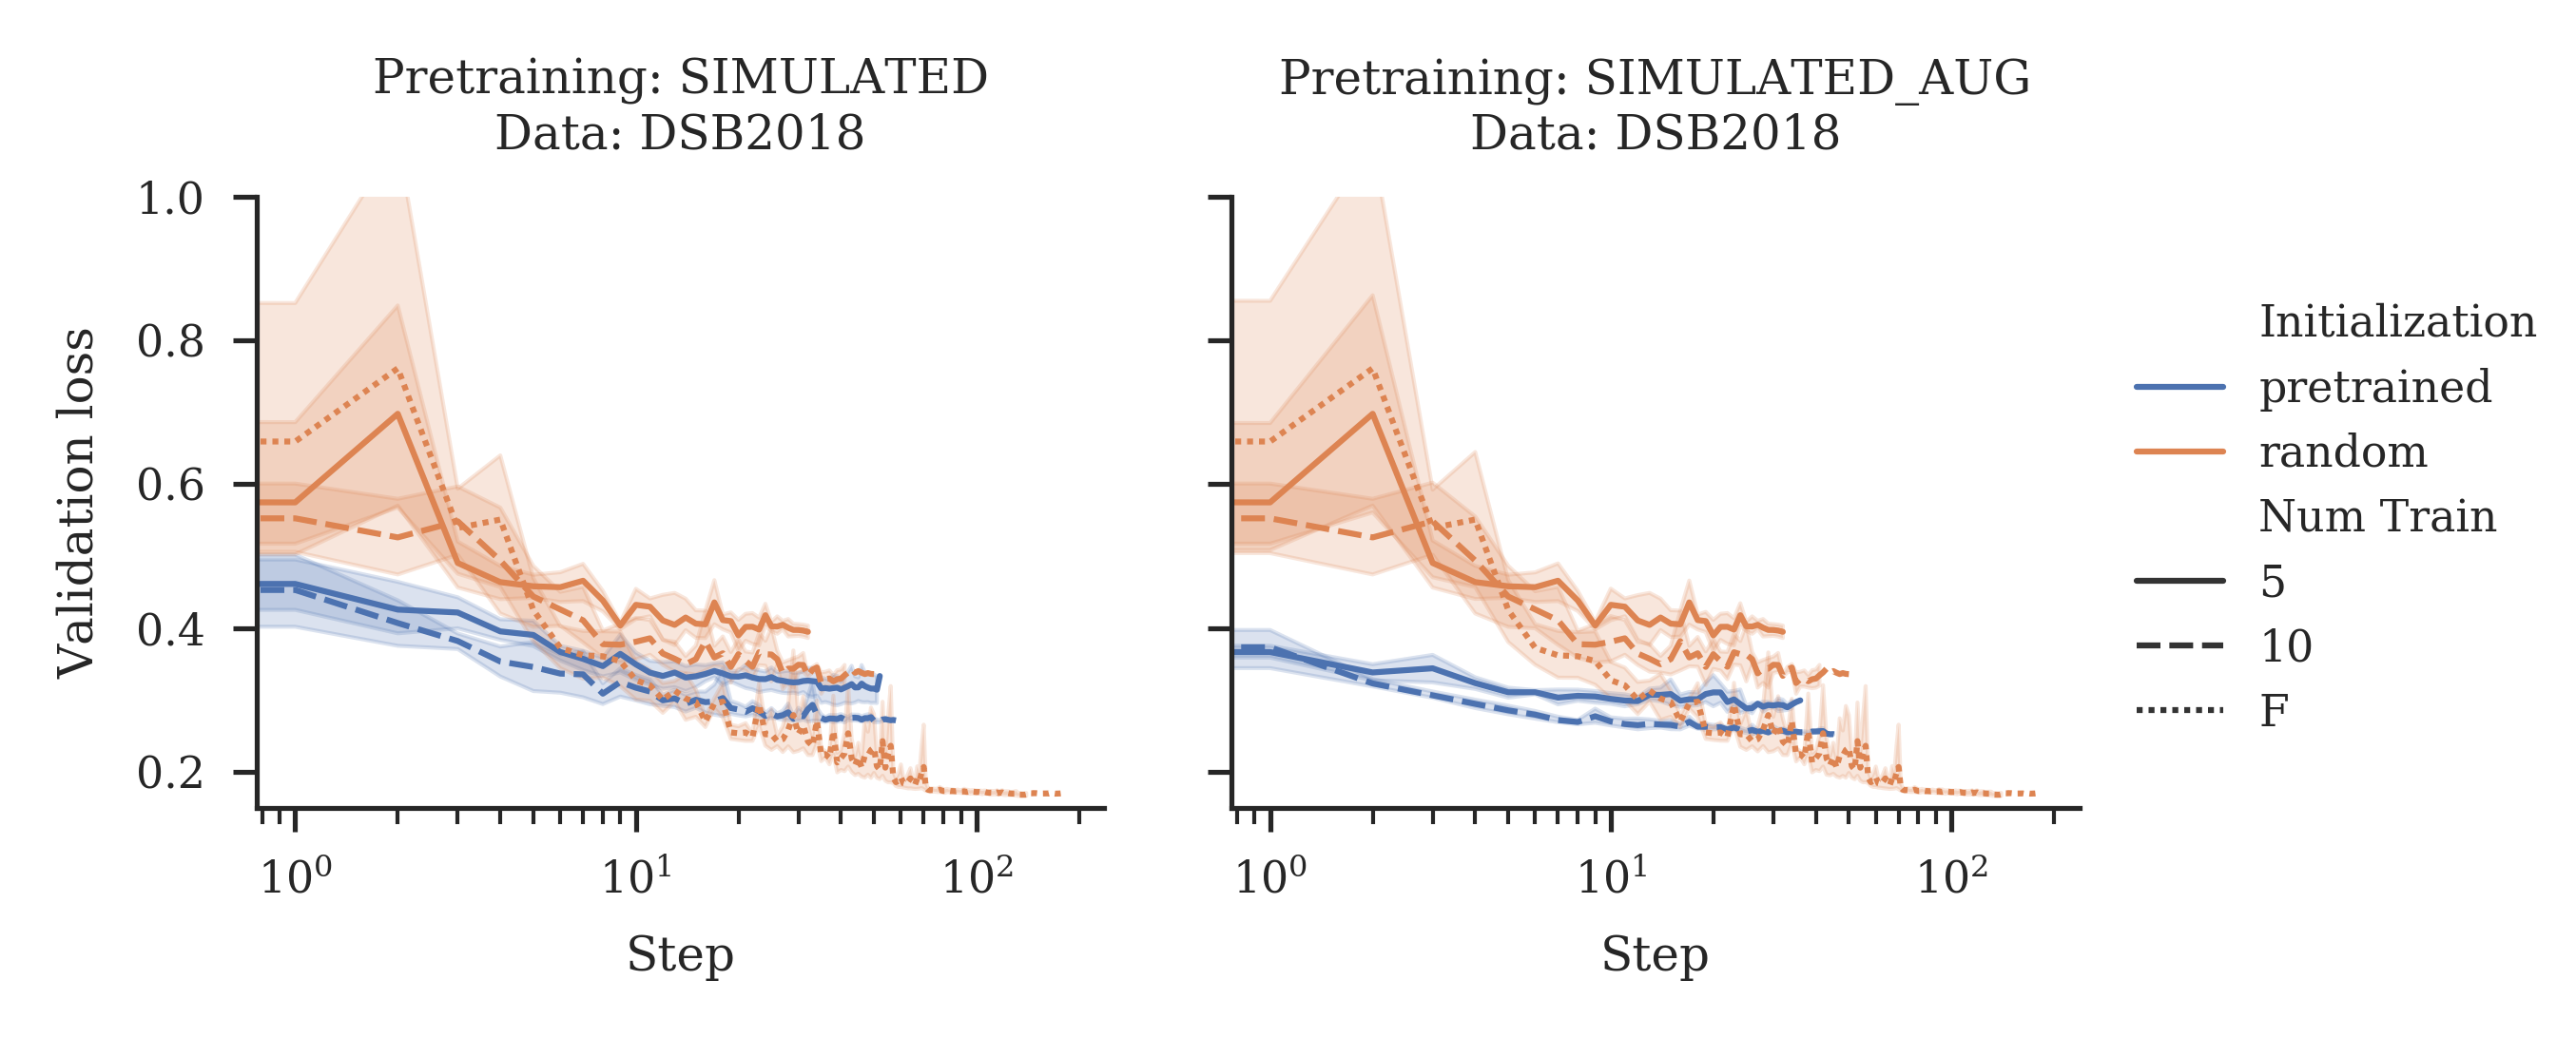

In [11]:
exps = [
    ('hl60low-granulocyte-aug', 'dsb2018', 'stardist', 'resnet-unet'),
    ('hl60low-hl60high-granulocyte', 'dsb2018', 'stardist', 'resnet-unet')
]
selected_models = visualize.get_models(exp_regex(exps))
history_df = visualize._get_model_histories_df(selected_models)

history_df = history_df[history_df['Num Train'].isin([5, 10, 'F'])]
history_df = fill_pretrain_data(history_df)
history_df = convert_to_categorical(history_df)
history_df = rename_datasets(history_df)
history_df = add_joined_data_col(history_df)
history_df['Validation loss'] = history_df['val_loss']


current_facetgrid_kwargs = dict(**facetgrid_kwargs)
g = sns.FacetGrid(
    data=history_df,
    col='Joined Data',
    col_order=['Pretraining: SIMULATED\nData: DSB2018',
               'Pretraining: SIMULATED_AUG\nData: DSB2018'],
    sharey=True, sharex=False, legend_out=True,
    **current_facetgrid_kwargs
)
g.map_dataframe(sns.lineplot, 'Step', 'Validation loss', style='Num Train', hue='Initialization')
plt.subplots_adjust(wspace=0.15)

g.set_titles(col_template = '{col_name}')
# Set the axis scales and lim
g.set(xscale='log')
g.axes[0,0].set(ylim=(0.15, 1))
g.axes[0,1].set(ylim=(0.15, 1))

g.add_legend()

visualize.save(g, '/tmp/bachelorthesis-plots-tex/history_mult.pdf')